In [44]:
import numpy as np
from PIL import Image
import PIL
import cv2
from pdf2image import convert_from_path
import math
import string
import json as j
import io
from google.cloud import vision_v1
import sys
import matplotlib.pyplot as plt
%matplotlib notebook

def toarr(image):
    if isinstance(image,PIL.PpmImagePlugin.PpmImageFile):
        image = np.array(image)
    r,c,_ = image.shape
    return image[:,int(c*0.07058823):int(c*0.92352941)]
    

def boundary(image):
    image = toarr(image)
    image1 = np.where(image < 50 , 0, 255)
    
    
    r,c,_ = image.shape
    dd = BreakPoints(image1[int(r*0.77):,:],0,x = int(c/2))

    ll = [ dd[i+1] - dd[i] for i in range(len( dd )-1)  ]
    image = image[:dd[ll.index(max(ll))]+int(r*0.77)+30,:,:]
    plt.imshow(image)
    r,c,_ = image.shape
    image = cv2.line(image,(0,0),(0,r),(255,255,255),30)
    image = cv2.line(image,(0,0),(c,0),(255,255,255),30)
    image = cv2.line(image,(0,r),(c,r),(255,255,255),30)
    image = cv2.line(image,(c,0),(c,r),(255,255,255),30)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blurred, 160,255,cv2.THRESH_BINARY_INV)[1]
    gray = np.float32(thresh)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    indices = np.argwhere((dst>0.01*dst.max()) == True)
    indlist = indices.tolist()
    
#     print ( filter(lambda x: x[1] == max(indlist, key=lambda x:x[1]), indlist)  )
    distances = np.linalg.norm(indices,axis = 1)
    sorted_distances = sorted(distances)
    start = indices[np.where(distances == sorted_distances[0] )[0][0],:]
    end = indices[np.where(distances == sorted_distances[-1] )[0][0],:]
    ran1 = list( filter(lambda x: help_bound(x,end[1],start[0]) , indlist)  )
    ran2 = list( filter(lambda x: help_bound(x,start[1],end[0]) , indlist)  )
#     print(start)
#     print(end)
    tr = (int(sum(x[0] for x in ran1)/len(ran1) ),int(sum(x[1] for x in ran1)/len(ran1) ))
#     print(tr)
    bl = (int(sum(x[0] for x in ran2)/len(ran2) ),int(sum(x[1] for x in ran2)/len(ran2) ))
#     print(bl)
    image = image[start[0]-10:end[0]+10,start[1]-10:end[1]+10]
    
    ptsf = np.float32([list(start),
    list(tr),
    list(bl),
    list(end),
    ])
    
    ptst = np.float32([list(start),
    [start[0],end[1]],
    [end[0],start[1]],
    list(end),
    ])
    return image

def help_bound(x,e,s):
    if (x[1] > e -20) and (x[1] < e + 20) and (x[0] > s - 20) and (x[0] < s +20):
          return x
          
          
def detect(sec,path,breaks = None,cut = None):
    file_path = path+".tiff"
    r,c,_ = sec.shape
    if cut is not None:
        cutf, cuts = cut
    else:
        cutf = 0
        cuts = 0
        
    if breaks is not None:
        for x in range(1,len(breaks)-2):
    #         breaks[x]:breaks[x+1]*int(r*0.080801551)
            print("yay",cutf,cuts,breaks[x],breaks[x+1]-int(r*0.080801551))
            cv2.line(sec,(cutf,breaks[x]),(cutf,breaks[x+1]-int(r*0.080801551)),(0,0,0),6)
            cv2.line(sec,(cuts,breaks[x]),(cuts,breaks[x+1]-int(r*0.080801551)),(0,0,0),6)
        cv2.line(sec,(cutf,breaks[-2]),(cutf,breaks[-1]),(0,0,0),6)
        cv2.line(sec,(cuts,breaks[-2]),(cuts,breaks[-1]),(0,0,0),6)


        cv2.imwrite(file_path,sec)
        client = vision_v1.ImageAnnotatorClient()
    mime_type = "image/tiff"
    with io.open(file_path, "rb") as f:
        content = f.read()
    input_config = {"mime_type": mime_type, "content": content}
    features = [{"type_": vision_v1.Feature.Type.DOCUMENT_TEXT_DETECTION}]

    pages = [1, 2, -1]
    requests = [{"input_config": input_config, "features": features, "pages": pages}]

    response = client.batch_annotate_files(requests=requests)
    LIST = []
    for image_response in response.responses[0].responses:
        for page in image_response.full_text_annotation.pages:
            for block in page.blocks:
                for par in block.paragraphs:
                    for word in par.words:
                        wor = []
                        for symbol in word.symbols:
                            wor.append(symbol.text)
                        LIST.append( ( [[v.x,v.y] for v in word.bounding_box.vertices],"".join(wor)) )
    return LIST


def blockIsIn(block,v):
    for x in block:
        if not isIn(x,v):
            return False
    return True

def isIn(p,v):
    return p[0]>v[0][0]-5 and p[0]<v[1][0]+5 and p[1]>v[0][1]-5 and p[1]<v[1][1]+5

def BreakPoints(a,adjust,x,total = None):
    r,c,_ = a.shape
    breakpoints = []
    breakpoints.append(0)
    change = False
    for row in range(0,a.shape[0]):
        if a[row,x,0] == 255:
            change = True
            
        if change and a[row,x,0] == 0:
            breakpoints.append(row-adjust)
            change = False
            if total is not None and len(breakpoints) == total:
                break
    return breakpoints   


def segmentation(a,d):
    r,c,_ = a.shape
    img = a.copy()
    img = np.where(img < 220, 0,img)
    
    img = cv2.blur(img , (10,3))
    img = np.where(img < 200 , 0,255)
    img = np.float32(img)
    plt.imshow(img)
    l = []
    for x in range(0,img[:,1200,0].shape[0]-60):
        l.append(( (img[x:x+d,1200,0]/255).sum() , x))
    sort = sorted(l,key = lambda x: x[0],reverse = False)
    pts = [0]
    def toadd(pts,pt):
        for x in pts:
            if abs(pt-x) < 100:
                return False
        return True
    for (s,x) in sort:
        if toadd(pts,x) and s < 10:
            pts.append(x)
    breakpoints = sorted(pts)
    breakpoints.append(r)
    sections = []
    for ind in range(len(breakpoints)-1):
        prevp = breakpoints[ind]
        nextp = breakpoints[ind+1]
        if abs(prevp-nextp) > 100:
            sections.append(a[prevp:nextp,0:c])
    return sections,breakpoints




def draw(img,cords):
    r,c,_ = img.shape
    for (a,b) in cords:        
        img = cv2.circle(img,a,5,(255,0,0),-1)
        img = cv2.circle(img,b,5,(0,0,0),-1)
    plt.imshow(img)

def extractsec1(LIST,c,z):
    RATINGLIST = []
    STATEL = []
    STATE = [(int(0.76*c), int(0.376*z)), (int(0.883*c), int(0.549*z))]
    RISKID = [(int(0.88*c), int(0.173*z)), (int(1*c),int(0.35*z))]
    RATINGEFFECTIVE = [(int(0.279*c), int(0.387*z)), (int(0.371*c), int(0.56*z))]
    PRODUCTION = [(int(0.565*c),int(0.383*z)),(int(0.663*c),int(0.564*z))]
    RISKNAME = [(int(0.193*c), int(0.214*z)), (int(0.632*c),int(0.346*z))]
    STATECODE = [(int(0*c),int(0.719*z)),(int(0.1800*c),int(0.86*z))]
    CARRIER = [(int(0.07*c),int(0.88*z)),(int(0.135*c),int(1*z))]
    EFF_DATE = [(int(0.553*c),int(0.88*z)),(int(0.651*c),int(1*z))]
    EXP_DATE = [(int(0.803*c),int(0.88*z)),(int(1*c),int(1*z))]
    POLICYNO = [(int(0.26*c),int(0.88*z)),(int(0.43*c),int(1*z))]
    sec1list = [STATE,RISKID,RATINGEFFECTIVE,PRODUCTION,RISKNAME,STATECODE,CARRIER,EFF_DATE,EXP_DATE,POLICYNO]

    RISKLIST = []
    risk_name = ""
    risk_id = ""
    rating_effective_date = ""
    production_date = ""
    state = ""
    state_code = ""
    carrier = ""
    eff = ""
    exp = ""
    pol = ""
    for ind,x in enumerate(LIST):
        if blockIsIn(x[0],RISKID):
            risk_id = x[1]
        if blockIsIn(x[0],RATINGEFFECTIVE):
            RATINGLIST.append(x[1])
        if blockIsIn(x[0],RISKNAME):
            RISKLIST.append(x[1])
        if blockIsIn(x[0],PRODUCTION):
            production_date = x[1]
        if blockIsIn(x[0],STATE):
            state = x[1]            
        if blockIsIn(x[0],STATECODE):
            STATEL.append(x[1])
        if blockIsIn(x[0],CARRIER):
            carrier = x[1]
        if blockIsIn(x[0],EFF_DATE):
            eff = x[1]
        if blockIsIn(x[0],EXP_DATE):
            exp = x[1]
        if blockIsIn(x[0],POLICYNO):
            pol = x[1]
        
    rating_effective_date = [x for x in RATINGLIST if ("/" in x)][0]
    risk_name =  " ".join(RISKLIST)
    state_code = " ".join(STATEL)

    if risk_name == "":
        print("Risk Name Not Found")
    if risk_id == "":
        print("Risk ID Not Found")
    if rating_effective_date == "":
        print("Rating Effective Not Found")
    if production_date == "":
        print("Production Date Not Found")
    if state == "":
        print("State Not Found")
    if state_code == "":
        print("State Code Not Found")
    if carrier == "":
        print("Carrier Not Found")
    if eff == "":
        print("Eff Date Not Found")
    if exp == "":
        print("Exp Date Not Found")
    if pol == "":
        print("Policy Number Not Found")
        
    temp = {
                            "risk_name": cleant(risk_name),
                            "risk_id": risk_id,
                            "rating_effective_date": rating_effective_date,
                            "production_date": production_date,
                            "state": state,
                            "carrier": carrier,
                            "policy_no": pol,
                            "eff_date": eff,
                            "exp_date": exp,
                            "code": "",
                            "elr": "",
                            "dratio": "",
                            "payroll": "",
                            "expected_losses": "",
                            "exp_prim_losses": "",
                            "claim_data": "",
                            "ij": "",
                            "of": "",
                            "act_inc_losses": "",
                            "act_prim_losses": "",
                            "statecode": state_code,
                            "Policy Total": "",
                            "Subject Premium": "",
                            "Total Act Inc Losses": ""
                        }
    return temp

def extractsec3(x,data):
    exsec2 = data.copy()
    claim_data = x[6]
    code = x[0]
    try:
        ij = int(x[7])
    except:
        ij = ""
    of = x[8] if len(x[8]) == 1 else ""
    try:
        act_inc_losses = x[9].replace(".",",").replace(",","")
    except:
        act_inc_losses = ""

    try:
        act_prim_losses = int(x[10].replace(".",",").replace(",",""))
    except:
        act_prim_losses = ""

    try:
        payroll = int(x[3].replace(",",""))
    except:
        payroll = ""

    try:
        elr = float(x[1].replace(" ","").replace(",","."))
    except:
        elr = x[1]
    try:
        expected_losses = int(x[4].replace(",",""))
    except:
        expected_losses = ""  

    try:
        dratio = float("."+(x[2].replace(" ","").replace(",","").replace(".","")))
    except:
        dratio = ""
    try:
        exp_prim_losses = int(x[5].replace(",",""))
    except:
        exp_prim_losses = "" 
    exsec2["claim_data"] = claim_data.translate(str.maketrans('', '', '!"#%&\'()*+,-./:;<=>?@[\\]^_`{|}~'))
    exsec2["code"] = code
    exsec2["ij"] = str(ij)
    exsec2["of"] = of
    exsec2["act_inc_losses"] = str(act_inc_losses)
    exsec2["act_prim_losses"] = str(act_prim_losses)
    exsec2["payroll"] = str(payroll)
    exsec2["elr"] = str(elr)
    exsec2["expected_losses"] = expected_losses
    exsec2["dratio"] = str(dratio)
    exsec2["exp_prim_losses"] = exp_prim_losses
    exsec2["claim_data"] = claim_data
        
    return exsec2

def same(P,a,b):
    p = P.copy()
    r , c ,_= p.shape
    rm = 50
    wid = 20
    if c > 2500:
        rm = 100
        print("here")
    p = np.where(p < 170 , 0,255)
    a = cv2.blur(p , (a,1))
    a = np.where(a > rm , 255,0)
    
    a = cv2.line(np.float32(a), (0,0), (c, 0), (0, 0, 0), thickness=20)
    hlist = [BreakPoints(a,0,x) for x in range(0,c,10)]
    h = sorted(hlist, key = lambda x: len(x), reverse = True)[0]
    h.append(r)
    h = hcheck(h)
    a = cv2.blur(p , (1,b))
    a = np.where(a > rm , 255,0)
    line_thickness = 2
    for x in h:
        a = cv2.line(np.float32(a), (0, x), (c, x), (0, 0, 0), thickness=line_thickness)
    a = cv2.line(a, (0, 0), (0, r), (0, 0, 0), thickness=10)    
    a = cv2.line(a, (c,0), (c, r), (0, 0, 0), thickness=10)
    
    yy = []
    cords = []
    y = 0
    ignore_first = False
    for ind in range(1,len(h)):
        d = (h[ind] - h[ind-1])
        mid0 = int(h[ind-1] + (d/2) )
        mid1 = int(h[ind-1] + (d/4) )
        mid2 = int(h[ind-1] + (3*d/4) )
        sprev = 0
        MID = None
        for mid in [mid0,mid1,mid2]:
            s = 0
            temp_cords = []
            temp_yy = []
            for x in range(c):
                if a[mid,x].sum() == 0 and ignore_first and abs(y-x) > wid and abs(h[ind] - h[ind-1]) > 20:
                    if x < y:
                        y = x
                        continue
                    temp_cords.append([(y,h[ind-1]),(x,h[ind])])
                    name = np.uint8(P[h[ind-1]:h[ind],y:x,:])
                    temp_yy.append(name)
                    y = x
                elif a[mid,x].sum() == 0:
                    ignore_first = True
            if len(temp_yy) !=0 and len(temp_cords) != 0:
                s = s+len(temp_yy)
            if s > sprev:
                MID = mid
                sprev = s
                
        temp_cords = []
        temp_yy = []
        ignore_first = False
        for x in range(c):
            if a[MID,x].sum() == 0 and ignore_first and abs(y-x) > wid and abs(h[ind] - h[ind-1]) > 20:
                if x < y:
                    y = x
                    continue
                temp_cords.append([(y,h[ind-1]),(x,h[ind])])
                name = np.uint8(P[h[ind-1]:h[ind],y:x,:])
                temp_yy.append(name)
                y = x
            elif a[MID,x].sum() == 0:
                ignore_first = True
        if len(temp_yy) !=0 and len(temp_cords) != 0:
            yy.append(temp_yy)
            cords.append(temp_cords)
    
    return yy,cords,len(h)

def clean(t):
    return t.translate(str.maketrans('', '', '!"$%&\'()+/:;<=>?@[\\]^_`{|}~')).strip()
def cleant(t):
    return t.translate(str.maketrans('', '', string.punctuation)).strip()


def arrange(array):
    if len(array) == 1:
        return array
    ret = []
    intx = []
    for x in array:
        try:
            ret.append(intx.append(int(x)))
        except:
            ret.append(x)
    return ret
    
def extract3(text_detections_in_order,temp):    
    assert len(text_detections_in_order) <= 4
    for ind , x in enumerate(text_detections_in_order):
        if x != "":
            if ind == 0:
                poltotal = [int(word) for word in cleant(x).split() if word.isdigit()]
            if ind == 1:
                subprem = [int(word) for word in cleant(x).split() if word.isdigit()]
            if ind == 2:
                total_act_inc_loss = [int(word) for word in cleant(x).split() if word.isdigit()]
    try:
        polt = poltotal[0]
    except:
        polt = "0"
        
    try:
        subp = subprem[0]
    except:
        subp = "0"
        
    try:
        totala = total_act_inc_loss[0]
    except:
        totala = "0"
    print(type(polt))
    temp["Policy Total"] = polt
    temp["Subject Premium"] = subp
    temp["Total Act Inc Losses"] = totala
    return temp
    
def extract4(LIST,data,r,c,b):
    temp = data.copy()
    CARRIER = [(c*0.07675,r-50+b),(c*0.14198,r+b)]
    POL = [(0.25864*c,r-50+b),(c*0.38373,r+b)]
    EFF = [(c*0.55488,r-50+b ),(c*0.65464,r+b)]
    EXP = [(c*0.801228,r-50+b),(0.90560*c,r+b)]
    STATECODE = [(0,r-100+b),(0.18*c,r-40+b)]
    
    ll = [CARRIER,POL,EFF,EXP,STATECODE]
    pol = ""
    carrier = ""
    eff = ""
    exp = ""
    state_code = ""
    STATEC = []
    EFFL = []
    EXPL = []
    
    
    for ind,x in enumerate(LIST):
        if blockIsIn(x[0],CARRIER):
            carrier = x[1]
        if blockIsIn(x[0],POL):
            pol = x[1]
        if blockIsIn(x[0],EFF):
            EFFL.append(x[1])
        if blockIsIn(x[0],EXP):
            EXPL.append(x[1])
        if blockIsIn(x[0],STATECODE):
            STATEC.append(x[1])
            
    state_code = "".join(STATEC)
    eff = "".join(EFFL)
    exp = "".join(EXPL)
    
    
    
    assert isinstance(carrier,str) and len(carrier) > 4
    assert isinstance(pol,str) and len(pol) > 4
    assert isinstance(eff,str) and len(eff) > 4
    assert isinstance(exp,str) and len(exp) > 4
    assert isinstance(state_code,str) and len(state_code) > 4

    temp["carrier"] = carrier
    temp["policy_no"] = pol
    temp["eff_date"] = eff
    temp["exp_date"] = exp
    temp["statecode"] = state_code
    return temp

def check1(text_detections_row):
    for x in text_detections_row:
        if "total" in x.lower().strip():
            return True
    return False

def hcheck(l):
    newl = [0]
    prev = newl[0]
    for x in range(1,len(l)):
        if abs(prev - l[x]) > 35:
            newl.append(l[x])
            prev = l[x]
    return newl
        
def secondpage(det):
    for (ptr,text) in det:
        if "stabiliz" in text.lower().strip():
            return True
    return False



In [55]:
# path = sys.argv[-2]
path = "/home/cs225/Desktop/nirav9033688351-attachments/Ramirashool NCCI PDF task instructions/pdfs/scanned/20210630101336848.pdf"
json = {
            "id": "",
            "document_id": "",
            "remote_id": "",
            "file_name": path.split("/")[-1],
            "media_link": "",
            "media_link_original": "",
            "media_link_data": "",
            "page_count": "",
            "uploaded_at": "",
            "processed_at": "",
            "merged_amit_data_edit": []
}
im = convert_from_path(path)
json["page_count"] = str(len(im))
json

{'document_id': '',
 'file_name': '20210630101336848.pdf',
 'id': '',
 'media_link': '',
 'media_link_data': '',
 'media_link_original': '',
 'merged_amit_data_edit': [],
 'page_count': '4',
 'processed_at': '',
 'remote_id': '',
 'uploaded_at': ''}

In [56]:
temp_list = []
polFound = True
for page in range(1,int(json["page_count"])):
    bound = boundary(im[page])
    bound = cv2.cvtColor(bound, cv2.COLOR_RGB2GRAY)
    bound = cv2.cvtColor(bound, cv2.COLOR_GRAY2RGB)
    
    r,c,_ = bound.shape
    
    if c > 2500:
        print("resizing")
        bound = cv2.resize(bound, (1300,1670), interpolation = cv2.INTER_AREA)
        
    r,c,_ = bound.shape
    if r < 1300:
        r = 1670
    plt.imshow(bound)
    
    secs,breakpoints = segmentation(bound,int(r*0.03588516746))
    if len(secs) > 1:
        small_block,cords,hlen = same(secs[-1],int(c*0.03846153846),int(c*0.02307692307))
        det = detect(bound,"page"+str(page),breakpoints,(cords[1][6][0][0]+5,cords[1][6][1][0]))
    else:
        det = detect(bound,"page"+str(page),breakpoints)
        
    
    
    if secondpage(det):
        continue
    sta = 1
    
    
#     print(det)
    if not polFound and len(det) < 50:
        plt.imshow(bound [BreakPoints(bound,0,c-50)[1]: ,:])
        det = detect( bound [BreakPoints(bound,0,c-50)[1]: ,:] ,"page"+str(page),breakpoints)
        inorderminus1 = []
        for _,x in det:
            try:
                x = int(x.replace(",",""))
                inorderminus1.append("ABC "+str(x))
            except:
                pass
        inorderminus1.append("")
        inorderminus1.pop(0)
        print(inorderminus1)
        temp = extract3(inorderminus1,t)
#         print("TEMP",temp)
        for x in range(len(temp_list)-1,-1,-1):
            if temp_list[x]["Policy Total"] == 10101010101:
                temp_list[x]["Policy Total"] = temp["Policy Total"]
                temp_list[x]["Subject Premium"] = temp["Subject Premium"]
                temp_list[x]["Total Act Inc Losses"] = temp["Total Act Inc Losses"]
            else:
                break
        polFound = True
#         print("SKIPPING")
        continue

    elif not polFound:
#         print("POLNOTFOUND")
        B = bound [BreakPoints(bound,0,c-20)[1]: ,:]
        secs,breakpoints = segmentation(B,int(r*0.03588516746))
        det = detect( B ,"page"+str(page),breakpoints)
        r,c,_ = B.shape
        
        if secs[0].shape[0] > 320:
            sta = 0
    else:
        t = extractsec1(det,c,breakpoints[1])
#     break
    print(len(secs),"secs in page",page)

#     print(temp)
    for sec_n in range(sta,len(secs)):
        sec = secs[sec_n].copy()
        small_block,cords,hlen = same(sec,int(c*0.03846153846),int(c*0.02307692307))
        print("Sec",sec_n,"of page",page,"has",hlen-1,"rows")
#         plt.imshow(small_block[0][0])
#         break
        text_detections_in_order = []
        for indr,row in enumerate(cords):
            text_detections_row = []
#             print("row",row)
            for indc, ((tlr,tlc),(brr,brc)) in enumerate(row):
                text_detections_col = []
                for ind_d, (block_detection,text) in enumerate(det):
                    if blockIsIn(block_detection,((tlr,tlc+breakpoints[sec_n]),(brr,brc+breakpoints[sec_n]))):
#                         print("text",text,(tlr,tlc),(brr,brc),breakpoints[sec_n],indr,indc,"\tsec",sec_n,"page",page)
                        text_detections_col.append(text)
#                 for x in text_detections_col:
#                     print("x",len(x))
#                 print("appending",text_detections_col)
#                 rearranged = arrange(text_detections_col)
#                 print("rearr",rearranged)

                
                to_add = clean(" ".join(text_detections_col))
                if "com" in to_add.lower().strip():
                    continue
                text_detections_row.append(to_add)
            if check1(text_detections_row):
                text_detections_in_order.append(text_detections_row)
                break       
            if len(text_detections_row) != 1:
                text_detections_in_order.append(text_detections_row)
        text_detections_in_order[-1].pop(-1)
        print(text_detections_in_order)
        print(page)
        if len(text_detections_in_order[-1]) < 5:
            temp = extract3(text_detections_in_order[-1],t)
            for x in range(len(temp_list)-1,-1,-1):
                if temp_list[x]["Policy Total"] == 10101010101:
                    temp_list[x]["Policy Total"] = temp["Policy Total"]
                    temp_list[x]["Subject Premium"] = temp["Subject Premium"]
                    temp_list[x]["Total Act Inc Losses"] = temp["Total Act Inc Losses"]
                else:
                    break
            polFound = True
        else:
            text_detections_in_order.append(["a 10101010101","a 10101010101","a 10101010101",""])
            temp = extract3(text_detections_in_order[-1],t)
            polFound = False
        print(len(text_detections_in_order))
        print(text_detections_in_order)
        for x in range(1,len(text_detections_in_order)-1):
            row = text_detections_in_order[x]
            if len(row) != 11:
                row.insert(2,"")
                row.insert(3,"")
                print(row)
                temp1 = extractsec3(row,temp)
            else:
                temp1 = extractsec3(row,temp)
            temp_list.append(temp1)
        try:
            t = extract4( det,t,sec.shape[0],c,breakpoints[sec_n]).copy()
#             break
        except:
#             print("PASSING")
            pass
#         break
#     break
                
print( "Total Records Found:", len(temp_list))
json["merged_amit_data_edit"] = temp_list
json_base = []
json_base.append(json)
# with open("/home/ramishrasool/Desktop/nirav9033688351-attachments/Ramirashool NCCI PDF task instructions/JSONs"+"/"+path.split("/")[-1].split(".")[0]+'.json', 'w') as fp:
#         j.dump(json_base, fp,indent = 4)
# sys.argv[-1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yay 738 901 281 499
yay 738 901 623 841
yay 738 901 965 1183
5 secs in page 1
Sec 1 of page 1 has 6 rows
[['Code', 'ELR', 'D-', 'Payroll', 'Expected Losses', 'Exp Prim Losses', 'Claim Data', 'IJ', '', '', 'Inc', 'Act Prim Losses'], ['3076', '2.56', ', 33', '462,378', '11,837', '3,906', 'NO . 3', 'b6', '', '1,486', '1,486'], ['8810', '.13', '.33', '398,624', '518', '171', '16007500', '06', 'F', '2,442', '2,442'], ['9812', 'EMPLOYERS LIABILIT', '0', '0', '', '', '', '', ''], ['Policy Total  861,002', 'Subject Premium  24,156', 'Total Act Inc Losses', '3,928']]
1
<class 'int'>
5
[['Code', 'ELR', 'D-', 'Payroll', 'Expected Losses', 'Exp Prim Losses', 'Claim Data', 'IJ', '', '', 'Inc', 'Act Prim Losses'], ['3076', '2.56', ', 33', '462,378', '11,837', '3,906', 'NO . 3', 'b6', '', '1,486', '1,486'], ['8810', '.13', '.33', '398,624', '518', '171', '16007500', '06', 'F', '2,442', '2,442'], ['9812', 'EMPLOYERS LIABILIT', '0', '0', '', '', '', '', ''], ['Policy Total  861,002', 'Subject Premium  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yay 740 901 282 503
yay 740 901 624 845
yay 740 901 966 1187
5 secs in page 2
Sec 1 of page 2 has 6 rows
[['Code', 'ELR', 'D.', 'Payroll', 'Expected Losses', 'Exp Prim Losses', 'Claim Data', 'IJ', 'OF', '', 'Act Inc Losses', 'Act Prim Losses'], ['8742', '.10', '.33', '105,621', '106', '35', '', '', '', '', ''], ['9807', 'EMPLOYERS LIABILIT', '0', '0', '', '', '', '', ''], ['9848', 'MINIMUM PREMIUM FO', '0', '0', '', '', '', '', ''], ['Policy Total  105,621', 'Subject Premium  863', 'Total Act Inc Losses', '0']]
2
<class 'int'>
5
[['Code', 'ELR', 'D.', 'Payroll', 'Expected Losses', 'Exp Prim Losses', 'Claim Data', 'IJ', 'OF', '', 'Act Inc Losses', 'Act Prim Losses'], ['8742', '.10', '.33', '105,621', '106', '35', '', '', '', '', ''], ['9807', 'EMPLOYERS LIABILIT', '0', '0', '', '', '', '', ''], ['9848', 'MINIMUM PREMIUM FO', '0', '0', '', '', '', '', ''], ['Policy Total  105,621', 'Subject Premium  863', 'Total Act Inc Losses', '0']]
['9807', 'EMPLOYERS LIABILIT', '', '', '0', '0', '', 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yay 733 896 283 501
yay 733 896 589 806
4 secs in page 3
Sec 1 of page 3 has 5 rows
[['Code', 'ELR', 'D', 'Payroll', 'Expected Losses', 'Exp Prim Losses', 'Claim Data', 'IJ', 'OFI', '', 'Act Inc', 'Act Prim Losses'], ['8742', '.15', '.36', '78,765', '118', '42', '', '', '', '', ''], ['9812', 'EMPLOYERS LIABILIT', '0', '이', '이', '', '', '', ''], ['78,765 Policy Total', 'Subject Premium  400', 'Total Act Inc Losses', '']]
3
<class 'int'>
4
[['Code', 'ELR', 'D', 'Payroll', 'Expected Losses', 'Exp Prim Losses', 'Claim Data', 'IJ', 'OFI', '', 'Act Inc', 'Act Prim Losses'], ['8742', '.15', '.36', '78,765', '118', '42', '', '', '', '', ''], ['9812', 'EMPLOYERS LIABILIT', '0', '이', '이', '', '', '', ''], ['78,765 Policy Total', 'Subject Premium  400', 'Total Act Inc Losses', '']]
['9812', 'EMPLOYERS LIABILIT', '', '', '0', '이', '이', '', '', '', '']
Sec 2 of page 3 has 5 rows
[['Code', 'ELR', 'D', 'Payroll', 'Expected', 'Exp Prim', 'Claim Data', 'IJ', 'OF', '', 'Inc', '', 'Prim'], ['8742', '.15'

In [57]:
# for indr,row in enumerate(cords):
#     for indc, ((tlr,tlc),(brr,brc)) in enumerate(row):
#         print(indr,indc,((tlr,tlc),(brr,brc)))
temp_list

[{'Policy Total': 861002,
  'Subject Premium': 24156,
  'Total Act Inc Losses': '0',
  'act_inc_losses': '1486',
  'act_prim_losses': '1486',
  'carrier': '24740',
  'claim_data': 'NO . 3',
  'code': '3076',
  'dratio': '0.33',
  'eff_date': '08/01/2016',
  'elr': '2.56',
  'exp_date': '01/01/2017',
  'exp_prim_losses': 3906,
  'expected_losses': 11837,
  'ij': '',
  'of': '',
  'payroll': '462378',
  'policy_no': 'WCPIA0000002439',
  'production_date': '10/13/2020',
  'rating_effective_date': '01/01/2021',
  'risk_id': '911229218',
  'risk_name': 'METAL WORKS INC',
  'state': 'INTERSTATE',
  'statecode': '14 - IOWA'},
 {'Policy Total': 861002,
  'Subject Premium': 24156,
  'Total Act Inc Losses': '0',
  'act_inc_losses': '2442',
  'act_prim_losses': '2442',
  'carrier': '24740',
  'claim_data': '16007500',
  'code': '8810',
  'dratio': '0.33',
  'eff_date': '08/01/2016',
  'elr': '0.13',
  'exp_date': '01/01/2017',
  'exp_prim_losses': 171,
  'expected_losses': 518,
  'ij': '6',
  'of

<IPython.core.display.Javascript object>


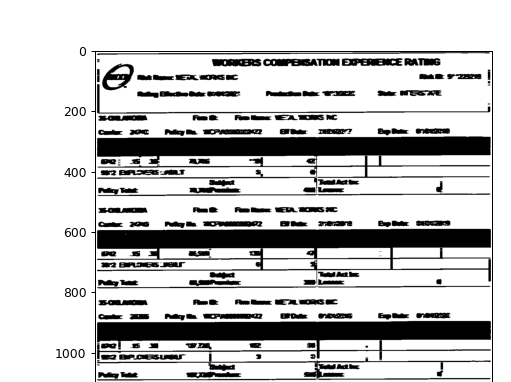

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yay 747 898 282 528
yay 747 898 661 944
yay 747 898 1077 1286


[0, 282, 661, 1077, 1419, 1656]

In [53]:
bound = boundary(im[4])

bound = cv2.cvtColor(bound, cv2.COLOR_RGB2GRAY)
bound = cv2.cvtColor(bound, cv2.COLOR_GRAY2RGB)
# print(BreakPoints(bound,0,c-10))
# bound = bound [BreakPoints(bound,0,c-10)[1]: ,:]
# bound = cv2.resize(bound, (1300,1670), interpolation = cv2.INTER_AREA)
# r,c,_ = bound.shape
# if r < 1300:
#     r = 1670

# print(r)
small_block,cords,hlen = same(secs[-1],int(c*0.03846153846),int(c*0.02307692307))
secs , breaks = segmentation(bound,int(r*0.03588516746))
det = detect(bound,"page"+str(1),breaks,(cords[1][6][0][0]+5,cords[1][6][1][0]))

# _,l = extractsec1(det,c,breaks[1])
# draw(bound,l)

# d = [(390, 49), (519, 72)]
# img = cv2.circle(bound,d[0],5,(255,0,0),-1)
# img = cv2.circle(img,d[1],5,(255,0,0),-1)
# plt.imshow(img)
# bound = np.where(bound< 170 , 0,255)

# hlen
# plt.imshow(small_block[2][-1])
# print(cords[2][0])
# bound = img

# ret, thresh = cv2.threshold(thresh, 127, 255, 0)
# b = cv2.blur(thresh , (50,1))
# c , h =  cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# bound = cv2.drawContours(img, c, -1, (0,255,0), 1)
# print(len(secs))
# extractsec1(det,c,breaks[1],bound)
plt.imshow(bound)
cords[1][6]
# plt.imshow(secs[1])
# plt.imshow(im[1])

# hlen
breaks
# breaks
# secs[0].shape
# len(small_block[0][3])
# len(secs)
# len(cords)
# draw(bound,sec1list,0,0,breaks[1])
# 
# print(bound.shape)
# breaks
# plt.imshow( bound [BreakPoints(bound,0,1385)[1]: ,:] )
# det = detect( bound [BreakPoints(bound,0,c-50)[1]: ,:] ,"page"+str(page))
# [(((tl1,tl2),(tr1,tr2),(br1,br2),(bl1,bl2)),text) for (((tl1,tl2),(tr1,tr2),(br1,br2),(bl1,bl2)),text) in det if tl2 < breaks[1]]

<IPython.core.display.Javascript object>


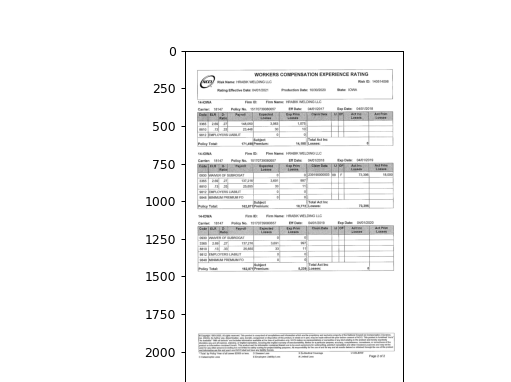

In [32]:
image = toarr(im[1])
plt.imshow(image)
r,c,_ = image.shape
plt.imshow()

In [92]:
for (a,b,c,d),y in det:
    image = cv2.circle(bound,a,3,(0,0,255),2)
    image = cv2.circle(image,b,3,(0,255,0),2)
    image = cv2.circle(image,c,3,(255,0,0),2)
    image = cv2.circle(image,d,3,(0,0,0),2)
    
plt.imshow(image)
    

NameError: name 'det' is not defined

In [99]:
det

[([[143, 39], [212, 39], [212, 65], [143, 65]], 'Rating'),
 ([[223, 39], [318, 39], [318, 65], [223, 65]], 'Effective'),
 ([[328, 39], [376, 39], [376, 65], [328, 65]], 'Date'),
 ([[380, 38], [383, 38], [383, 64], [380, 64]], ':'),
 ([[393, 38], [508, 38], [508, 63], [393, 64]], '09/11/2019'),
 ([[604, 41], [725, 41], [725, 62], [604, 62]], 'Production'),
 ([[735, 41], [783, 41], [783, 62], [735, 62]], 'Date'),
 ([[787, 41], [790, 41], [790, 62], [787, 62]], ':'),
 ([[804, 41], [919, 41], [919, 62], [804, 62]], '07/25/2019'),
 ([[1004, 41], [1059, 41], [1059, 62], [1004, 62]], 'State'),
 ([[1063, 41], [1066, 41], [1066, 62], [1063, 62]], ':'),
 ([[1085, 41], [1227, 41], [1227, 62], [1085, 62]], 'INTERSTATE'),
 ([[3, 125], [27, 125], [27, 148], [3, 148]], '09'),
 ([[30, 125], [35, 125], [35, 148], [30, 148]], '-'),
 ([[38, 125], [140, 125], [140, 148], [38, 148]], 'FLORIDA'),
 ([[342, 125], [389, 125], [389, 146], [342, 146]], 'Firm'),
 ([[399, 125], [419, 125], [419, 146], [399, 146]],

In [122]:
inorderminus1 = []
for _,x in det:
    try:
#         print(x)
        x = int(x.replace(",",""))
        inorderminus1.append("ABC "+str(x))
    except:
        pass
inorderminus1.append("")
inorderminus1

['ABC 9',
 'ABC 30406',
 'ABC 8',
 'ABC 284220',
 'ABC 4803',
 'ABC 1873',
 'ABC 94023',
 'ABC 17000',
 'ABC 35',
 'ABC 83048',
 'ABC 1320',
 'ABC 451',
 'ABC 451',
 'ABC 594',
 'ABC 1936',
 'ABC 6',
 'ABC 37',
 'ABC 4965',
 'ABC 962',
 'ABC 962',
 'ABC 212165',
 'ABC 374398',
 'ABC 173',
 'ABC 1498',
 'ABC 674',
 'ABC 1286',
 'ABC 1286',
 'ABC 173',
 'ABC 259724',
 'ABC 1039',
 'ABC 468',
 'ABC 173',
 'ABC 40',
 'ABC 53907',
 'ABC 216',
 'ABC 97',
 'ABC 173',
 'ABC 40',
 'ABC 33821',
 'ABC 135',
 'ABC 61',
 'ABC 173',
 'ABC 40',
 'ABC 78790',
 'ABC 315',
 'ABC 142',
 'ABC 930',
 'ABC 0',
 'ABC 0',
 'ABC 2105',
 'ABC 167335',
 'ABC 3564',
 'ABC 1604',
 'ABC 3040',
 'ABC 4496',
 'ABC 1619',
 'ABC 156658',
 'ABC 20332',
 'ABC 3179',
 'ABC 207',
 'ABC 93',
 'ABC 3724',
 'ABC 15775',
 'ABC 205',
 'ABC 66',
 'ABC 3724',
 'ABC 8915',
 'ABC 2853',
 'ABC 4299',
 'ABC 685806',
 'ABC 93063',
 'ABC 33410',
 'ABC 912',
 'ABC 410',
 'ABC 5022',
 'ABC 1286',
 'ABC 412',
 'ABC 5102',
 'ABC 77346',
 '

In [84]:
extract3(inorderminus1,temp)

{'risk_name': 'EMPLOYER PAYROLL SOLUTIONS INC',
 'risk_id': '914245192',
 'rating_effective_date': '09/11/2019',
 'production_date': '07/25/2019',
 'state': 'INTERSTATE',
 'carrier': '39071',
 'policy_no': 'TWC3509986',
 'eff_date': '10/01/2015',
 'exp_date': '10/01/2016',
 'code': '',
 'elr': '',
 'dratio': '',
 'payroll': '',
 'expected_losses': '',
 'exp_prim_losses': '',
 'claim_data': '',
 'ij': '',
 'of': '',
 'act_inc_losses': '',
 'act_prim_losses': '',
 'statecode': '09 - FLORIDA',
 'Policy Total': 6418754,
 'Subject Premium': 198585,
 'Total Act Inc Losses': 547521}

In [54]:
s = sorted(det, key = lambda x: x[0][0][1])
s

[([[1023, 18], [1133, 18], [1133, 46], [1023, 46]], 'RATING'),
 ([[818, 19], [1011, 18], [1011, 46], [818, 47]], 'EXPERIENCE'),
 ([[562, 20], [804, 19], [804, 47], [562, 48]], 'COMPENSATION'),
 ([[392, 21], [550, 20], [550, 48], [392, 49]], 'WORKERS'),
 ([[1074, 71], [1116, 71], [1116, 91], [1074, 91]], 'Risk'),
 ([[1124, 71], [1142, 71], [1142, 91], [1124, 91]], 'ID'),
 ([[1146, 71], [1148, 71], [1148, 91], [1146, 91]], ':'),
 ([[1165, 71], [1270, 71], [1270, 91], [1165, 91]], '914103703'),
 ([[142, 73], [184, 73], [184, 95], [142, 95]], 'Risk'),
 ([[192, 73], [247, 73], [247, 95], [192, 95]], 'Name'),
 ([[250, 73], [253, 73], [253, 95], [250, 95]], ':'),
 ([[266, 73], [358, 73], [358, 95], [266, 95]], 'CENTRIA'),
 ([[366, 73], [506, 73], [506, 95], [366, 95]], 'KEALTHCARE'),
 ([[515, 73], [551, 73], [551, 95], [515, 95]], 'LLC'),
 ([[38, 74], [111, 72], [112, 94], [39, 96]], 'NCCI'),
 ([[935, 125], [985, 125], [985, 147], [935, 147]], 'State'),
 ([[989, 125], [991, 125], [991, 147], 

In [6]:
!pip3 install numpy

  Using cached https://files.pythonhosted.org/packages/45/b2/6c7545bb7a38754d63048c7696804a0d947328125d81bf12beaa692c3ae3/numpy-1.19.5-cp36-cp36m-manylinux1_x86_64.whl


In [31]:
!export GOOGLE_APPLICATION_CREDENTIALS="C:\Users\DANIYAL's PC\Desktop\Ramish\nirav9033688351-attachments\nirav9033688351-attachments"

'export' is not recognized as an internal or external command,
operable program or batch file.
